<a href="https://colab.research.google.com/github/kevinknights29/Regression--Battery-Life-Prediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 7.8 MB/s eta 0:00:00


In [ ]:
# libraries and modules
# data availability
import requests
import zipfile
from pathlib import Path
# data preparation
import scipy.io
import pandas as pd
import numpy as np
import datetime
from scipy.stats import kurtosis, skew
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# modeling
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch

In [ ]:
# config
# %matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

## Data Availability

In [ ]:
dataset_url = 'https://phm-datasets.s3.amazonaws.com/NASA/5.+Battery+Data+Set.zip'
dataset_zip = "5.+Battery+Data+Set.zip"

response = requests.get(dataset_url)
with open(dataset_zip, "wb") as f:
  f.write(response.content)

In [ ]:
with zipfile.ZipFile(dataset_zip, "r") as f:
    f.extractall(".")
Path(dataset_zip).unlink()

In [ ]:
for zip in Path(".").rglob("*.zip"):
  with zipfile.ZipFile(zip, "r") as f:
    output_folder = zip.parent / zip.stem
    f.extractall(output_folder)
  Path(zip).unlink()

## Framework

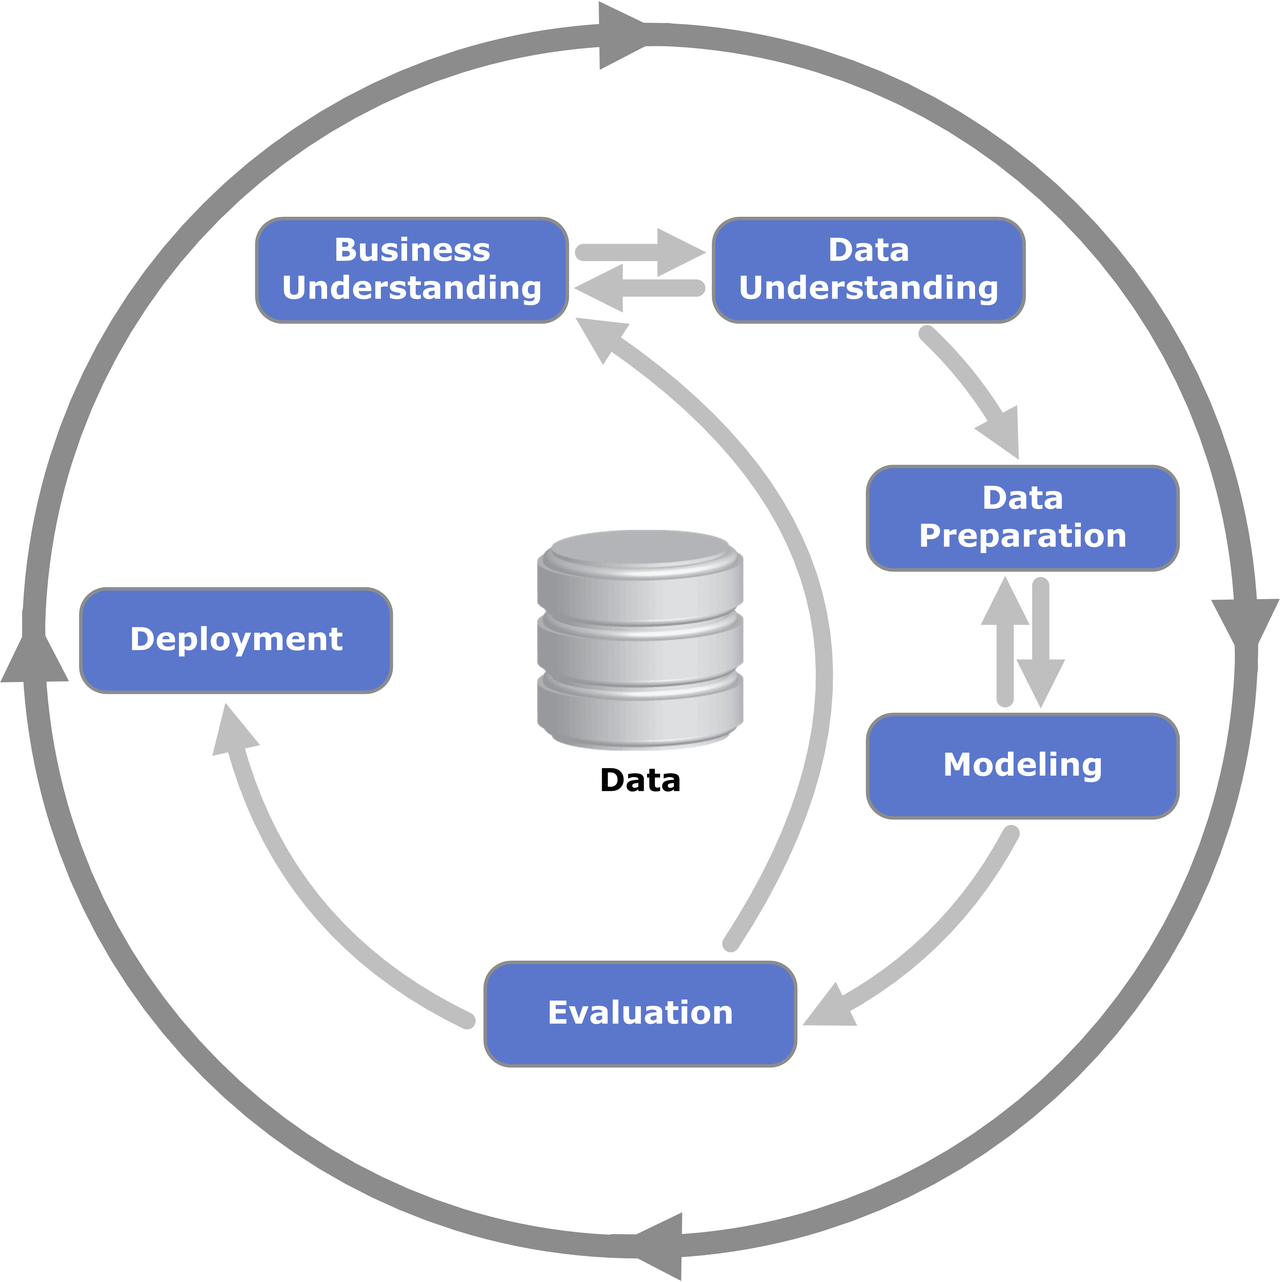

## Data Preparation

Data Description:
A set of four Li-ion batteries (# 5, 6, 7 and 18) were run through 3 different operational profiles (charge, discharge and impedance) at room temperature.
<br>
<br>
Charging was carried out in a constant current (CC) mode at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA.
<br>
<br>
Discharge was carried out at a constant current (CC) level of 2A until the battery voltage fell to 2.7V, 2.5V, 2.2V and 2.5V for batteries 5 6 7 and 18 respectively.
<br>
<br>
Impedance measurement was carried out through an electrochemical impedance spectroscopy (EIS) frequency sweep from 0.1Hz to 5kHz. Repeated charge and discharge cycles result in accelerated aging of the batteries while impedance measurements provide insight into the internal battery parameters that change as aging progresses.
<br>
<br>
The experiments were stopped when the batteries reached end-of-life (EOL) criteria, which was a 30% fade in rated capacity (from 2Ahr to 1.4Ahr). This dataset can be used for the prediction of both remaining charge (for a given discharge cycle) and remaining useful life (RUL).

<br>

---


Files:
*   B0005.mat	Data for Battery #5
*   B0006.mat	Data for Battery #6
*   B0007.mat	Data for Battery #7
*   B0018.mat	Data for Battery #18

<br>

---


Data Structure:
*   cycle:	top level structure array containing the charge, discharge and impedance operations
	*   type: 	operation  type, can be charge, discharge or impedance
	*   ambient_temperature:	ambient temperature (degree C)
	*   time: 	the date and time of the start of the cycle, in MATLAB  date vector
  *    data:	data structure containing the measurements
      *   for charge the fields are:
      ```
          Voltage_measured: 	Battery terminal voltage (Volts)
          Current_measured:	Battery output current (Amps)
          Temperature_measured: 	Battery temperature (degree C)
          Current_charge:		Current measured at charger (Amps)
          Voltage_charge:		Voltage measured at charger (Volts)
          Time:			Time vector for the cycle (secs)
      ```
      <br>

      *    for discharge the fields are:
      ```
          Voltage_measured: 	Battery terminal voltage (Volts)
          Current_measured:	Battery output current (Amps)
          Temperature_measured: 	Battery temperature (degree C)
          Current_charge:		Current measured at load (Amps)
          Voltage_charge:		Voltage measured at load (Volts)
          Time:			Time vector for the cycle (secs)
          Capacity:		Battery capacity (Ahr) for discharge till 2.7V
      ```
      <br>

      *    for impedance the fields are:
      ```
          Sense_current:		Current in sense branch (Amps)
          Battery_current:	Current in battery branch (Amps)
          Current_ratio:		Ratio of the above currents
          Battery_impedance:	Battery impedance (Ohms) computed from raw data
          Rectified_impedance:	Calibrated and smoothed battery impedance (Ohms)
          Re:			Estimated electrolyte resistance (Ohms)
          Rct:			Estimated charge transfer resistance (Ohms)
      ```



In [ ]:
  # Docs:
  # inside a matrix we have the following structure
  # [0][0][0][0][2][3][0][0][5]
  #                          ^
  #                        column
  #                 ^
  #                data
  #              ^
  #             type
  #
  # type: [charge | discharge | impedance]
  # data: [structure
  # columns if charge: ["voltage_measured", "Current_measured","Temperature_measured","Current_charge","Voltage_charge","Time"]
  # columns if discharge: ["voltage_measured", "Current_measured","Temperature_measured","Current_charge","Voltage_charge","Time","Capacity"]
  # columns if impedance: ["Sense_current","Battery_current","Current_ratio","Battery_impedance","Rectified_impedance""Re","Rct"]
  #
  # =========================================================================================================================================

  column_structure = {
    "discharge": [
      "voltage_measured",
      "current_measured",
      "temperature_measured",
      "current_charge",
      "voltage_charge",
      "time",
      "capacity",
    ],
    "impedance": [
      "sense_current",
      "battery_current",
      "current_ratio",
      "battery_impedance",
      "rectified_impedance",
      "re",
      "rct",
    ],
    "charge": [
     "voltage_measured",
     "current_measured",
     "temperature_measured",
     "current_charge",
     "voltage_charge",
     "time",
    ],
}

In [ ]:
def _convert_row_data_to_df(row_data, columns):
  data_dict = {
      column: pd.Series(row_data[0][idx][0][:]) for idx, column in enumerate(columns)
  }
  data_df = pd.DataFrame(data=data_dict)
  return data_df

In [ ]:
def _convert_data_dict_to_df(data_dict, data_key, data_type):
  dfs = []
  for val in data_dict[data_key][data_type]:
    val_df = val[3].copy()
    val_df["type"] = val[0]
    val_df["temp"] = val[1]
    val_df["time_exp"] = val[2]
    dfs.append(val_df)

  return pd.concat(dfs, ignore_index=True, sort=False)


In [ ]:
def load_mat(path):
  data_mat = scipy.io.loadmat(path)
  data_key = list(data_mat.keys())[-1]
  data_dict = {
      data_key: {
          "discharge": [],
          "impedance": [],
          "charge":    [],
      }
  }

  for idx, row in enumerate(data_mat[data_key][0][0][0][0]):
    row_type = row[0][0]
    row_temp = row[1][0][0]
    row_time = datetime.datetime(*map(int, row[2][0]))
    row_data = row[3][0]
    row_data_df = _convert_row_data_to_df(row_data, column_structure[row_type])
    # special case
    if "time" in row_data_df.columns:
      timedelta_col = pd.to_timedelta(row_data_df["time"], unit='s')
      row_data_df["time"] = row_time + timedelta_col

    data_dict[data_key][row_type].append([row_type, row_temp, row_time, row_data_df])

  discharge_data_df = _convert_data_dict_to_df(data_dict, data_key, "discharge")
  impedance_data_df = _convert_data_dict_to_df(data_dict, data_key, "impedance")
  charge_data_df = _convert_data_dict_to_df(data_dict, data_key, "charge")

  return pd.concat([discharge_data_df, impedance_data_df, charge_data_df], ignore_index=True, sort=False)

In [ ]:
mats = [mat for mat in Path(".").rglob("*.mat")]
mats = sorted(mats)
print(*mats, sep="\n")

5. Battery Data Set/1. BatteryAgingARC-FY08Q4/B0005.mat
5. Battery Data Set/1. BatteryAgingARC-FY08Q4/B0006.mat
5. Battery Data Set/1. BatteryAgingARC-FY08Q4/B0007.mat
5. Battery Data Set/1. BatteryAgingARC-FY08Q4/B0018.mat
5. Battery Data Set/2. BatteryAgingARC_25_26_27_28_P1/B0025.mat
5. Battery Data Set/2. BatteryAgingARC_25_26_27_28_P1/B0026.mat
5. Battery Data Set/2. BatteryAgingARC_25_26_27_28_P1/B0027.mat
5. Battery Data Set/2. BatteryAgingARC_25_26_27_28_P1/B0028.mat
5. Battery Data Set/3. BatteryAgingARC_25-44/B0025.mat
5. Battery Data Set/3. BatteryAgingARC_25-44/B0026.mat
5. Battery Data Set/3. BatteryAgingARC_25-44/B0027.mat
5. Battery Data Set/3. BatteryAgingARC_25-44/B0028.mat
5. Battery Data Set/3. BatteryAgingARC_25-44/B0029.mat
5. Battery Data Set/3. BatteryAgingARC_25-44/B0030.mat
5. Battery Data Set/3. BatteryAgingARC_25-44/B0031.mat
5. Battery Data Set/3. BatteryAgingARC_25-44/B0032.mat
5. Battery Data Set/3. BatteryAgingARC_25-44/B0033.mat
5. Battery Data Set/3. Ba

In [ ]:
def load_data(battery_file_path):
  mat = scipy.io.loadmat(battery_file_path)
  battery = Path(battery_file_path).stem
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []

  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]

In [ ]:
battery_1 = mats[0]
mat_df = load_mat(battery_1)

In [ ]:
dataset, capacity = load_data(battery_1)

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]


In [ ]:
dataset.head(5)

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1,24,2008-04-02 15:25:41,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000
1,1,24,2008-04-02 15:25:41,1.856487,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781
2,1,24,2008-04-02 15:25:41,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703
3,1,24,2008-04-02 15:25:41,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781
4,1,24,2008-04-02 15:25:41,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922


In [ ]:
dataset.describe()

,cycle,ambient_temperature,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.0,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,24.0,1.560345,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924
std,45.699687,0.0,0.182380,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295
min,1.000000,24.0,1.287453,2.455679,-2.029098,23.214802,-1.998400,0.000000,0.000000
25%,50.000000,24.0,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,24.0,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,24.0,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,24.0,1.856487,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000


## Exploratory Data Analysis

In [ ]:
# shape
dataset.shape

(50285, 10)

In [ ]:
# info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50285 entries, 0 to 50284
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   cycle                 50285 non-null  int64         
 1   ambient_temperature   50285 non-null  uint8         
 2   datetime              50285 non-null  datetime64[ns]
 3   capacity              50285 non-null  float64       
 4   voltage_measured      50285 non-null  float64       
 5   current_measured      50285 non-null  float64       
 6   temperature_measured  50285 non-null  float64       
 7   current_load          50285 non-null  float64       
 8   voltage_load          50285 non-null  float64       
 9   time                  50285 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), uint8(1)
memory usage: 3.5 MB


In [ ]:
dataset.dtypes

cycle                            int64
ambient_temperature              uint8
datetime                datetime64[ns]
capacity                       float64
voltage_measured               float64
current_measured               float64
temperature_measured           float64
current_load                   float64
voltage_load                   float64
time                           float64
dtype: object

In [ ]:
# Discharge Dataset
dataset.isnull().sum()

cycle                   0
ambient_temperature     0
datetime                0
capacity                0
voltage_measured        0
current_measured        0
temperature_measured    0
current_load            0
voltage_load            0
time                    0
dtype: int64

Text(0.5, 1.0, 'Discharge B0005')

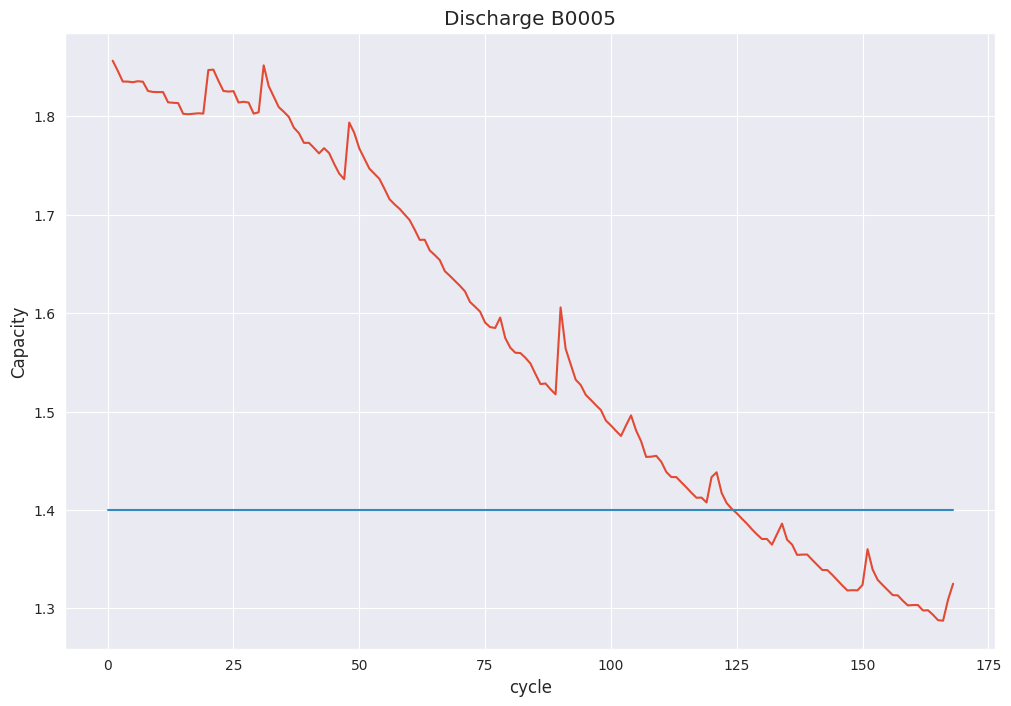

In [ ]:
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

<Figure size 1200x800 with 0 Axes>

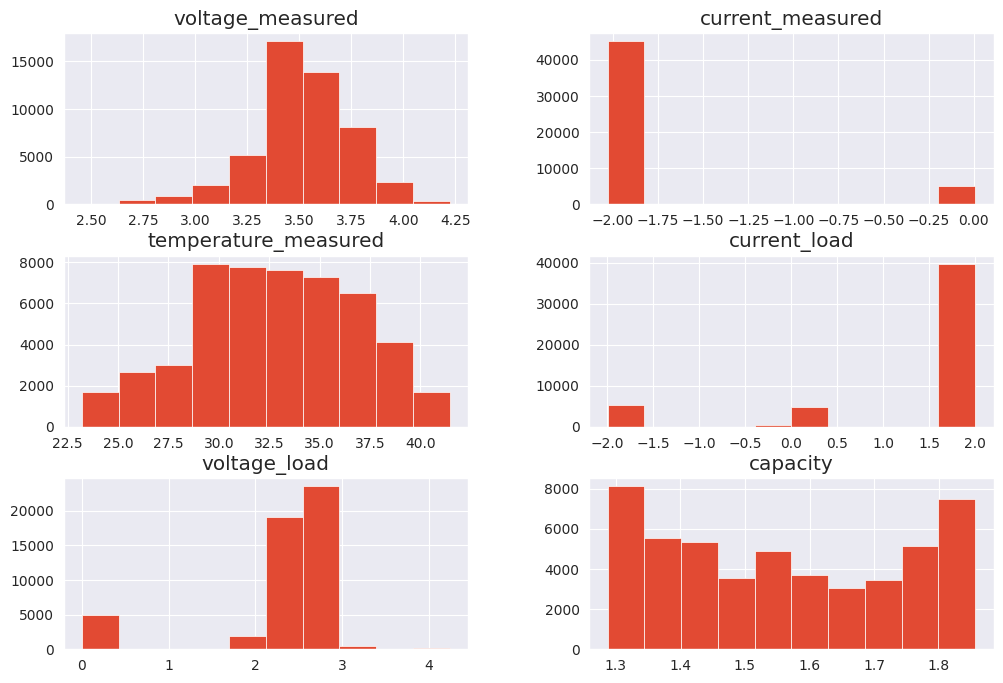

In [ ]:
# Discharge Histogram
columns_of_interest = ["voltage_measured", "current_measured", "temperature_measured", "current_load", "voltage_load", "capacity"]

plt.figure()
dataset.loc[:, columns_of_interest].hist()

plt.show()

In [ ]:
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


Text(0.5, 1.0, 'Discharge B0005')

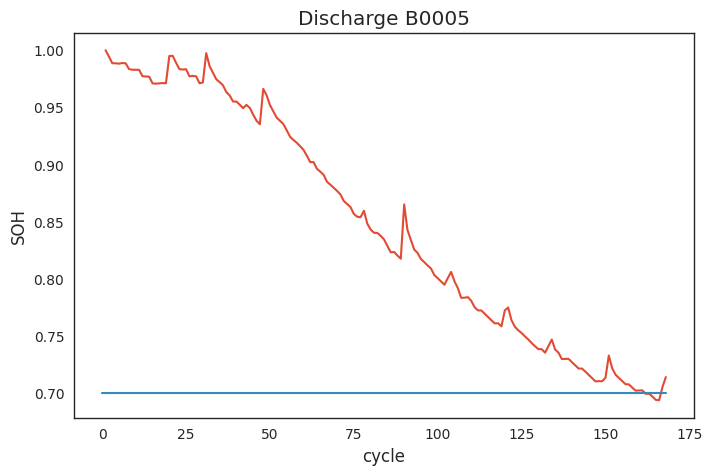

In [ ]:
plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

## Feature Engineering

In [ ]:
columns_of_interest = ['capacity', 'voltage_measured', 'current_measured', 'temperature_measured', 'current_load', 'voltage_load', 'time']
data = dataset[columns_of_interest].copy()

means = data.apply(np.mean)
variances = data.apply(np.var)
skewnesses = skew(data)
kurt = kurtosis(data)

print(f"Means:\n{means}", f"Variances:\n{variances}", f"Skewness:\n{skewnesses}", f"Kurtosis:\n{kurt}", sep="\n\n")

Means:
capacity                   1.560345
voltage_measured           3.515268
current_measured          -1.806032
temperature_measured      32.816991
current_load               1.362700
voltage_load               2.308406
time                    1546.208924
dtype: float64

Variances:
capacity                     0.033262
voltage_measured             0.053720
current_measured             0.372705
temperature_measured        15.899963
current_load                 1.725769
voltage_load                 0.640468
time                    821980.277682
dtype: float64

Skewness:
[ 0.11465034 -0.43812723  2.61797032 -0.13610722 -1.82835115 -2.2611816
  0.06225828]

Kurtosis:
[-1.41193035  1.17346376  4.85385007 -0.6451763   1.77536324  4.0357801
 -1.11246968]


In [ ]:
col = dataset["voltage_load"].copy()
col

0        0.000
1        4.206
2        3.062
3        3.030
4        3.011
         ...  
50280    0.000
50281    0.000
50282    0.000
50283    0.000
50284    0.000
Name: voltage_load, Length: 50285, dtype: float64

In [ ]:
from scipy.stats import boxcox

col = dataset["voltage_load"].copy()
transformed_col = boxcox(x=col, lmbda=0.5)

kurt = kurtosis(col)
transformed_kurt = kurtosis(transformed_col)
print(f"Regular Kurtosis:\n{kurt}", f"Transformed Kurtosis @ {0.5}:\n{transformed_kurt}", sep="\n\n")

Regular Kurtosis:
4.035780103516682

Transformed Kurtosis @ 0.5:
4.84189040726057


In [ ]:
from scipy.stats import boxcox

col = dataset["current_measured"].copy()
transformed_col = boxcox(x=col, lmbda=0.5)

kurt = kurtosis(col)
transformed_kurt = kurtosis(transformed_col)
print(f"Regular Kurtosis:\n{kurt}", f"Transformed Kurtosis @ {0.5}:\n{transformed_kurt}", sep="\n\n")

Regular Kurtosis:
4.853850068705413

Transformed Kurtosis @ 0.5:
nan


## Modeling

### SoH (state-of-health)

In [ ]:
C_0 = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C_0])
soh = pd.DataFrame(data=soh, columns=['SoH'])
target = soh.copy().to_numpy()
target.shape

(50285, 1)

In [ ]:
attribs=['capacity', 'voltage_measured', 'current_measured', 'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs].copy()

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
train_dataset.shape

(50285, 7)

In [ ]:
train_dataset

array([[1.00000000e+00, 9.82216203e-01, 9.93912495e-01, ...,
        4.99849880e-01, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 9.81795921e-01, 9.95593528e-01, ...,
        4.99849880e-01, 9.92449269e-01, 4.54740810e-03],
       [1.00000000e+00, 8.59640432e-01, 8.13621166e-03, ...,
        5.00400320e-05, 7.22510618e-01, 9.67499622e-03],
       ...,
       [6.61238996e-02, 6.38738471e-01, 9.94807358e-01, ...,
        5.00150120e-01, 0.00000000e+00, 7.58983848e-01],
       [6.61238996e-02, 6.40352345e-01, 9.96917596e-01, ...,
        5.00150120e-01, 0.00000000e+00, 7.61642758e-01],
       [6.61238996e-02, 6.41824310e-01, 9.96032820e-01, ...,
        5.00150120e-01, 0.00000000e+00, 7.64284866e-01]])

In [ ]:
base_model = Sequential()
base_model.add(Dense(8, activation='relu', input_dim=train_dataset.shape[1]))
base_model.add(Dense(8, activation='relu'))
base_model.add(Dense(8, activation='relu'))
base_model.add(Dropout(rate=0.25))
base_model.add(Dense(1))
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 64        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________


In [ ]:
base_model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=8, max_value=32, step=4),
                    activation='relu',
                    input_dim=train_dataset.shape[1]))

    for i in range(hp.Int('num_layers', min_value=1, max_value=4)):
        model.add(Dense(units=hp.Int(f'units_layer_{i}', min_value=8, max_value=32, step=4),
                        activation='relu'))

    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_absolute_error')

    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # The number of different models to try
    executions_per_trial=1,  # The number of times to train each model
    directory='random_search',
    project_name='battery_soh_optimization'
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# tuner.search(train_dataset, target,
#              batch_size=25, epochs=50,
#              validation_split=0.2,
#              callbacks=[early_stopping])

# best_model = tuner.get_best_models(num_models=1)[0]
# best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# print("Best Hyperparameters:")
# print(f"Units input: {best_hyperparameters.get('units_input')}")
# print(f"Num layers: {best_hyperparameters.get('num_layers')}")
# print(f"Dropout rate: {best_hyperparameters.get('dropout_rate')}")
# print(f"Learning rate: {best_hyperparameters.get('learning_rate')}")

# for i in range(best_hyperparameters.get('num_layers')):
#     print(f"Units layer {i}: {best_hyperparameters.get(f'units_layer_{i}')}")

In [ ]:
# Best Hyperparameters:
# Units input: 16
# Num layers: 1
# Dropout rate: 0.1
# Learning rate: 0.00010948067065592716
# Units layer 0: 16

optimized_model = Sequential()
optimized_model.add(Dense(16, activation='relu', input_dim=train_dataset.shape[1], kernel_regularizer=L1(0.01)))
optimized_model.add(Dense(16, activation='relu'))
optimized_model.add(Dropout(rate=0.1))
optimized_model.add(Dense(1))
optimized_model.summary()

optimizer = Adam(learning_rate=0.00010948067065592716,
                 beta_1=0.9, beta_2=0.999, epsilon=1e-08)
optimized_model.compile(optimizer=optimizer, loss='mean_absolute_error')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 16)                128       
                                                                 
 dense_8 (Dense)             (None, 16)                272       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________


In [ ]:
base_model.fit(x=train_dataset, y=target, batch_size=25, epochs=50)

Epoch 1/50
2012/2012 [==============================] - 15s 4ms/step - loss: 0.1251
Epoch 2/50
2012/2012 [==============================] - 7s 3ms/step - loss: 0.0329
Epoch 3/50
2012/2012 [==============================] - 7s 4ms/step - loss: 0.0306
Epoch 4/50
2012/2012 [==============================] - 7s 4ms/step - loss: 0.0227
Epoch 5/50
2012/2012 [==============================] - 7s 3ms/step - loss: 0.0224
Epoch 6/50
2012/2012 [==============================] - 7s 4ms/step - loss: 0.0225
Epoch 7/50
2012/2012 [==============================] - 7s 3ms/step - loss: 0.0223
Epoch 8/50
2012/2012 [==============================] - 8s 4ms/step - loss: 0.0225
Epoch 9/50
2012/2012 [==============================] - 7s 3ms/step - loss: 0.0221
Epoch 10/50
2012/2012 [==============================] - 8s 4ms/step - loss: 0.0220
Epoch 11/50
2012/2012 [==============================] - 7s 3ms/step - loss: 0.0222
Epoch 12/50
2012/2012 [==============================] - 7s 4ms/step - loss: 0.0226


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

optimized_model.fit(x=train_dataset, y=target, batch_size=25, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
1610/1610 [==============================] - 8s 4ms/step - loss: 0.4316 - val_loss: 0.2808
Epoch 2/50
1610/1610 [==============================] - 6s 4ms/step - loss: 0.2719 - val_loss: 0.2028
Epoch 3/50
1610/1610 [==============================] - 6s 4ms/step - loss: 0.2037 - val_loss: 0.1571
Epoch 4/50
1610/1610 [==============================] - 6s 3ms/step - loss: 0.1601 - val_loss: 0.1248
Epoch 5/50
1610/1610 [==============================] - 7s 4ms/step - loss: 0.1289 - val_loss: 0.0981
Epoch 6/50
1610/1610 [==============================] - 6s 4ms/step - loss: 0.1069 - val_loss: 0.0781
Epoch 7/50
1610/1610 [==============================] - 7s 4ms/step - loss: 0.0889 - val_loss: 0.0602
Epoch 8/50
1610/1610 [==============================] - 7s 4ms/step - loss: 0.0733 - val_loss: 0.0454
Epoch 9/50
1610/1610 [==============================] - 6s 4ms/step - loss: 0.0605 - val_loss: 0.0329
Epoch 10/50
1610/1610 [==============================] - 6s 4ms/step - loss: 0.049

In [ ]:
battery_2 = mats[1]
dataset_val, capacity_val = load_data(battery_2)
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]


In [ ]:
dataset_val.head(5)

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1,24,2008-04-02 15:25:41,2.035338,4.179800,-0.002366,24.277568,-0.0006,0.000,0.000
1,1,24,2008-04-02 15:25:41,2.035338,4.179823,0.000434,24.277073,-0.0006,4.195,16.781
2,1,24,2008-04-02 15:25:41,2.035338,3.966528,-2.014242,24.366226,-1.9990,3.070,35.703
3,1,24,2008-04-02 15:25:41,2.035338,3.945886,-2.008730,24.515123,-1.9990,3.045,53.781
4,1,24,2008-04-02 15:25:41,2.035338,3.930354,-2.013381,24.676053,-1.9990,3.026,71.922


In [ ]:
dis_ele.head(5)

,cycle,datetime,capacity,SoH
0,1,2008-04-02 15:25:41,2.035338,1.000000
1,2,2008-04-02 19:43:48,2.025140,0.994990
2,3,2008-04-03 00:01:06,2.013326,0.989185
3,4,2008-04-03 04:16:37,2.013285,0.989165
4,5,2008-04-03 08:33:25,2.000528,0.982898


In [ ]:
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
soh_pred_base = base_model.predict(sc.fit_transform(dataset_val[attrib]))
soh_pred_opt = optimized_model.predict(sc.fit_transform(dataset_val[attrib]))
print(soh_pred_base.shape, soh_pred_opt.shape, sep="\n")

1572/1572 [==============================] - 3s 2ms/step
(50285, 1)
(50285, 1)


In [ ]:
C = dataset_val['capacity'][0]
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH_Base'] = soh_pred_base
new_soh['NewSoH_Optimized'] = soh_pred_opt
new_soh = new_soh.groupby(['cycle']).mean().reset_index()

In [ ]:
new_soh.head(5)

,cycle,SoH,NewSoH_Base,NewSoH_Optimized
0,1,1.000000,0.957933,0.964947
1,2,0.994990,0.955273,0.961722
2,3,0.989185,0.952184,0.958115
3,4,0.989165,0.952170,0.958146
4,5,0.982898,0.948829,0.954236


In [ ]:
# Base Model:
# evaluate the model using various metrics
mae = metrics.mean_absolute_error(new_soh['SoH'], new_soh['NewSoH_Base'])
mse = metrics.mean_squared_error(new_soh['SoH'], new_soh['NewSoH_Base'])
rmse = metrics.mean_squared_error(new_soh['SoH'], new_soh['NewSoH_Base'], squared=False)
r2 = metrics.r2_score(new_soh['SoH'], new_soh['NewSoH_Base'])

# print the evaluation results
print("============ BASE MODEL ============")
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('R-squared:', r2)

============ BASE MODEL ============
MAE: 0.0767446528464113
MSE: 0.008130417046839295
RMSE: 0.09016882524930274
R-squared: 0.46660794707329545


In [ ]:
# Optimized Model:
# evaluate the model using various metrics
mae = metrics.mean_absolute_error(new_soh['SoH'], new_soh['NewSoH_Optimized'])
mse = metrics.mean_squared_error(new_soh['SoH'], new_soh['NewSoH_Optimized'])
rmse = metrics.mean_squared_error(new_soh['SoH'], new_soh['NewSoH_Optimized'], squared=False)
r2 = metrics.r2_score(new_soh['SoH'], new_soh['NewSoH_Optimized'])

# print the evaluation results
print("============ Optimized MODEL ============")
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('R-squared:', r2)

============ Optimized MODEL ============
MAE: 0.0593406709762823
MSE: 0.004942651138048174
RMSE: 0.07030399091124326
R-squared: 0.6757397778938143


Text(0.5, 1.0, 'Discharge B0006')

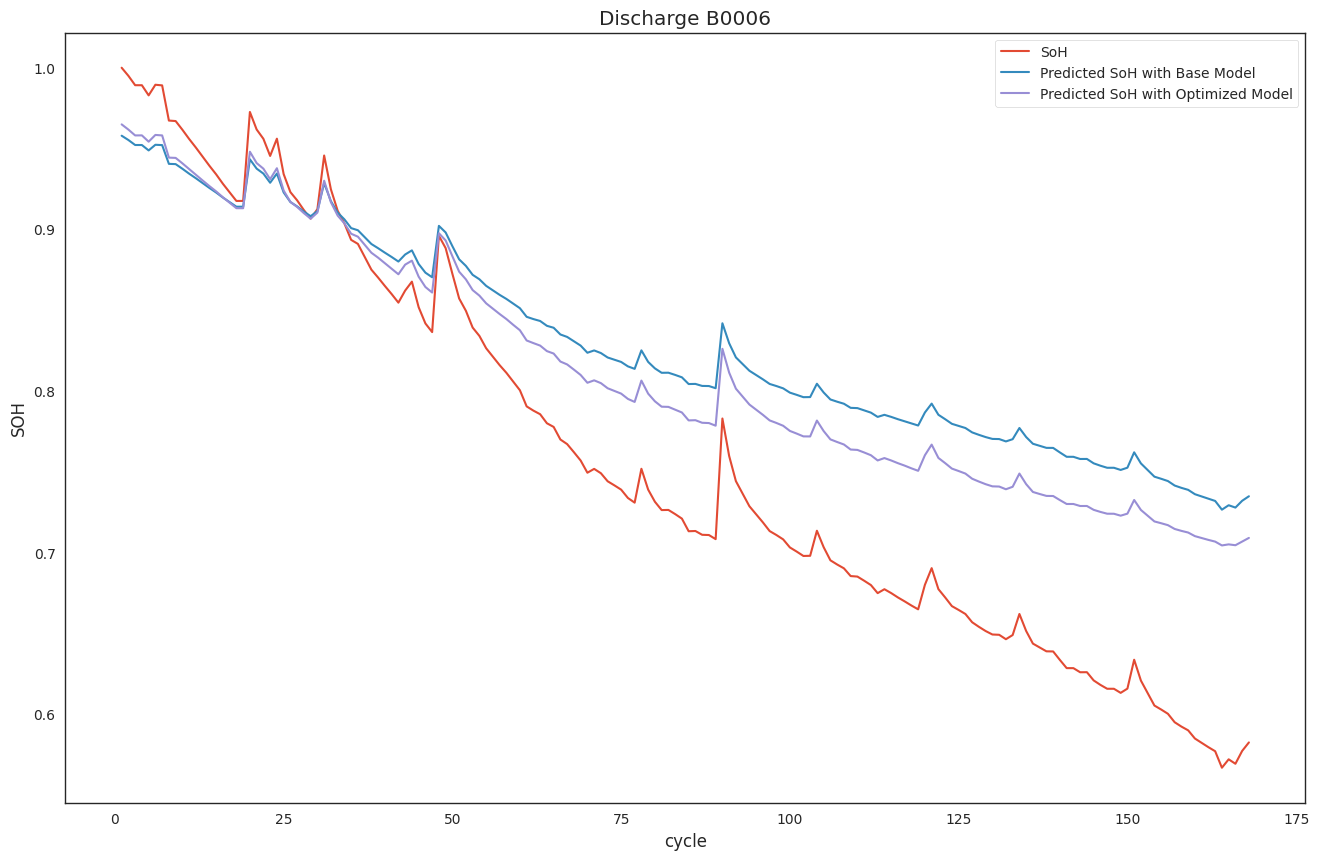

In [ ]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH_Base', 'NewSoH_Optimized']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH_Base'], label='Predicted SoH with Base Model')
plt.plot(plot_df['cycle'], plot_df['NewSoH_Optimized'], label='Predicted SoH with Optimized Model')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

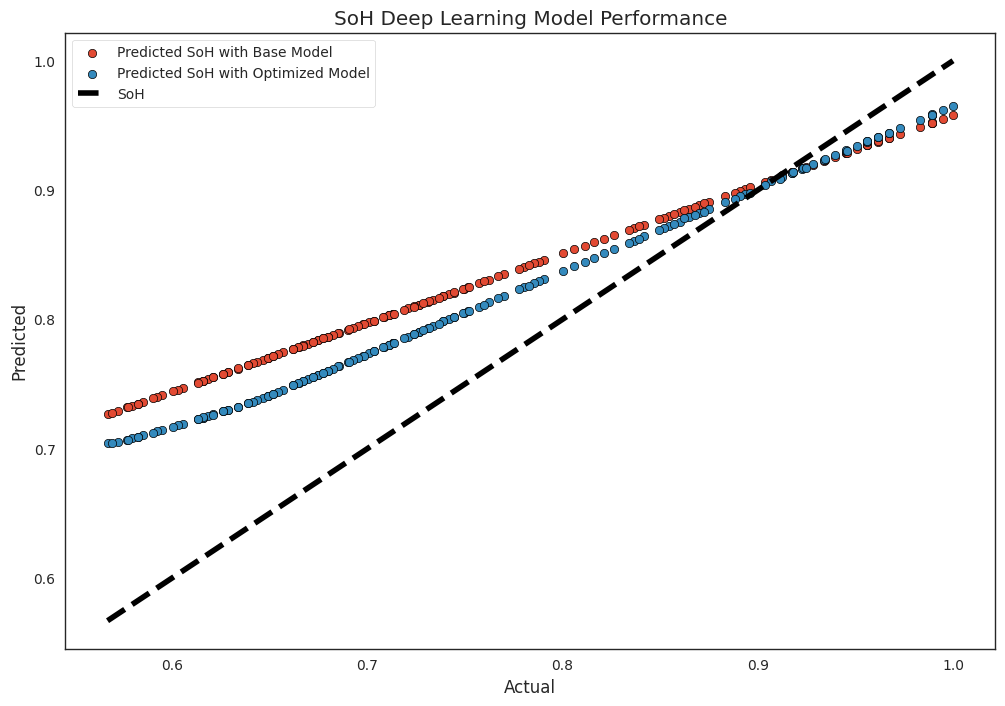

In [ ]:
# plot the predicted values against the actual values
fig, ax = plt.subplots()
ax.scatter(new_soh['SoH'], new_soh['NewSoH_Base'], edgecolors=(0, 0, 0), label='Predicted SoH with Base Model')
ax.scatter(new_soh['SoH'], new_soh['NewSoH_Optimized'], edgecolors=(0, 0, 0),label='Predicted SoH with Optimized Model')

ax.plot([new_soh['SoH'].min(), new_soh['SoH'].max()], [new_soh['SoH'].min(), new_soh['SoH'].max()], 'k--', lw=4, label='SoH')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('SoH Deep Learning Model Performance')
plt.legend()
plt.show()

### RUL

In [ ]:
dataset_val, capacity_val = load_data(battery_1)
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
rows=['cycle','capacity']
dataset=dis_ele[rows]
data_train=dataset[(dataset['cycle']<50)]
data_set_train=data_train.iloc[:,1:2].values
data_test=dataset[(dataset['cycle']>=50)]
data_set_test=data_test.iloc[:,1:2].values

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]


In [ ]:
sc=MinMaxScaler(feature_range=(0,1))
data_set_train=sc.fit_transform(data_set_train)
data_set_test=sc.transform(data_set_test)

In [ ]:
X_train=[]
y_train=[]
#take the last 10t to predict 10t+1
for i in range(10,49):
    X_train.append(data_set_train[i-10:i,0])
    y_train.append(data_set_train[i,0])
X_train,y_train=np.array(X_train),np.array(y_train)

X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

In [ ]:
# Base Model
base_regress = Sequential()
base_regress.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1)))
base_regress.add(Dropout(0.3))
base_regress.add(LSTM(units=200, return_sequences=True))
base_regress.add(Dropout(0.3))
base_regress.add(LSTM(units=200, return_sequences=True))
base_regress.add(Dropout(0.3))
base_regress.add(LSTM(units=200))
base_regress.add(Dropout(0.3))
base_regress.add(Dense(units=1))
base_regress.compile(optimizer='adam',loss='mean_squared_error')
base_regress.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 200)           161600    
                                                                 
 dropout_7 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_5 (LSTM)               (None, 10, 200)           320800    
                                                                 
 dropout_8 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_6 (LSTM)               (None, 10, 200)           320800    
                                                                 
 dropout_9 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_7 (LSTM)               (None, 200)              

In [ ]:
# Optimized Model
optimized_regress = Sequential()
optimized_regress.add(Bidirectional(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1))))
optimized_regress.add(Dropout(0.3))
optimized_regress.add(Bidirectional(LSTM(units=200, return_sequences=True)))
optimized_regress.add(Dropout(0.3))
optimized_regress.add(Bidirectional(LSTM(units=200, return_sequences=True)))
optimized_regress.add(Dropout(0.3))
optimized_regress.add(Bidirectional(LSTM(units=200)))
optimized_regress.add(Dropout(0.3))
optimized_regress.add(Dense(units=1))

initial_learning_rate = 0.001
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)

optimized_regress.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mean_squared_error')
optimized_regress.build(input_shape=(None, X_train.shape[1], 1))
optimized_regress.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 10, 400)          323200    
 nal)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 10, 400)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 10, 400)          961600    
 nal)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 10, 400)           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 10, 400)          961600    
 nal)                                                            
                                                      

In [ ]:
base_regress.fit(X_train, y_train, epochs=200, batch_size=25, validation_split=0.2)

Epoch 1/200
2/2 [==============================] - 8s 1s/step - loss: 0.3968 - val_loss: 0.0284
Epoch 2/200
2/2 [==============================] - 0s 44ms/step - loss: 0.1426 - val_loss: 0.3196
Epoch 3/200
2/2 [==============================] - 0s 37ms/step - loss: 0.1919 - val_loss: 0.0716
Epoch 4/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0339 - val_loss: 0.0269
Epoch 5/200
2/2 [==============================] - 0s 38ms/step - loss: 0.1194 - val_loss: 0.0255
Epoch 6/200
2/2 [==============================] - 0s 36ms/step - loss: 0.1321 - val_loss: 0.0296
Epoch 7/200
2/2 [==============================] - 0s 38ms/step - loss: 0.0902 - val_loss: 0.0541
Epoch 8/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0449 - val_loss: 0.1308
Epoch 9/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0464 - val_loss: 0.1841
Epoch 10/200
2/2 [==============================] - 0s 39ms/step - loss: 0.0572 - val_loss: 0.1380
Epoch 11/200
2/2 [===

In [ ]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training
optimized_regress.fit(X_train, y_train, epochs=200, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/200
2/2 [==============================] - 17s 3s/step - loss: 0.3652 - val_loss: 0.0973
Epoch 2/200
2/2 [==============================] - 0s 57ms/step - loss: 0.0706 - val_loss: 0.0304
Epoch 3/200
2/2 [==============================] - 0s 51ms/step - loss: 0.0515 - val_loss: 0.0783
Epoch 4/200
2/2 [==============================] - 0s 45ms/step - loss: 0.0428 - val_loss: 0.0905
Epoch 5/200
2/2 [==============================] - 0s 45ms/step - loss: 0.0448 - val_loss: 0.0336
Epoch 6/200
2/2 [==============================] - 0s 43ms/step - loss: 0.0518 - val_loss: 0.0331
Epoch 7/200
2/2 [==============================] - 0s 45ms/step - loss: 0.0458 - val_loss: 0.0683
Epoch 8/200
2/2 [==============================] - 0s 44ms/step - loss: 0.0345 - val_loss: 0.0803
Epoch 9/200
2/2 [==============================] - 0s 42ms/step - loss: 0.0301 - val_loss: 0.0445
Epoch 10/200
2/2 [==============================] - 0s 44ms/step - loss: 0.0336 - val_loss: 0.0352
Epoch 11/200
2/2 [==

In [ ]:
print(len(data_test))
data_total=pd.concat((data_train['capacity'], data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)

119


In [ ]:
X_test=[]
for i in range(10,129):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [ ]:
pred_base=base_regress.predict(X_test)
pred_base.shape

4/4 [==============================] - 1s 5ms/step


(119, 1)

In [ ]:
pred_opt=optimized_regress.predict(X_test)
pred_opt.shape

4/4 [==============================] - 3s 8ms/step


(119, 1)

In [ ]:
pred_base=sc.inverse_transform(pred_base)
pred_base=pred_base[:,0]

pred_opt=sc.inverse_transform(pred_opt)
pred_opt=pred_opt[:,0]

In [ ]:
tests=data_test.iloc[:,1:2]

In [ ]:
# Base Model:
# evaluate the model using various metrics
mae = metrics.mean_absolute_error(tests, pred_base)
mse = metrics.mean_squared_error(tests, pred_base)
rmse = metrics.mean_squared_error(tests, pred_base, squared=False)
r2 = metrics.r2_score(tests, pred_base)

# print the evaluation results
print("============ BASE MODEL ============")
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('R-squared:', r2)

============ BASE MODEL ============
MAE: 0.28031158805384165
MSE: 0.08932653888937189
RMSE: 0.29887545715460123
R-squared: -3.87857742201453


In [ ]:
# Optimized Model:
# evaluate the model using various metrics
mae = metrics.mean_absolute_error(tests, pred_opt)
mse = metrics.mean_squared_error(tests, pred_opt)
rmse = metrics.mean_squared_error(tests, pred_opt, squared=False)
r2 = metrics.r2_score(tests, pred_opt)

# print the evaluation results
print("============ Optimized MODEL ============")
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('R-squared:', r2)

============ Optimized MODEL ============
MAE: 0.16376830112727772
MSE: 0.03284316275180998
RMSE: 0.18122682679948346
R-squared: -0.7937324591403456


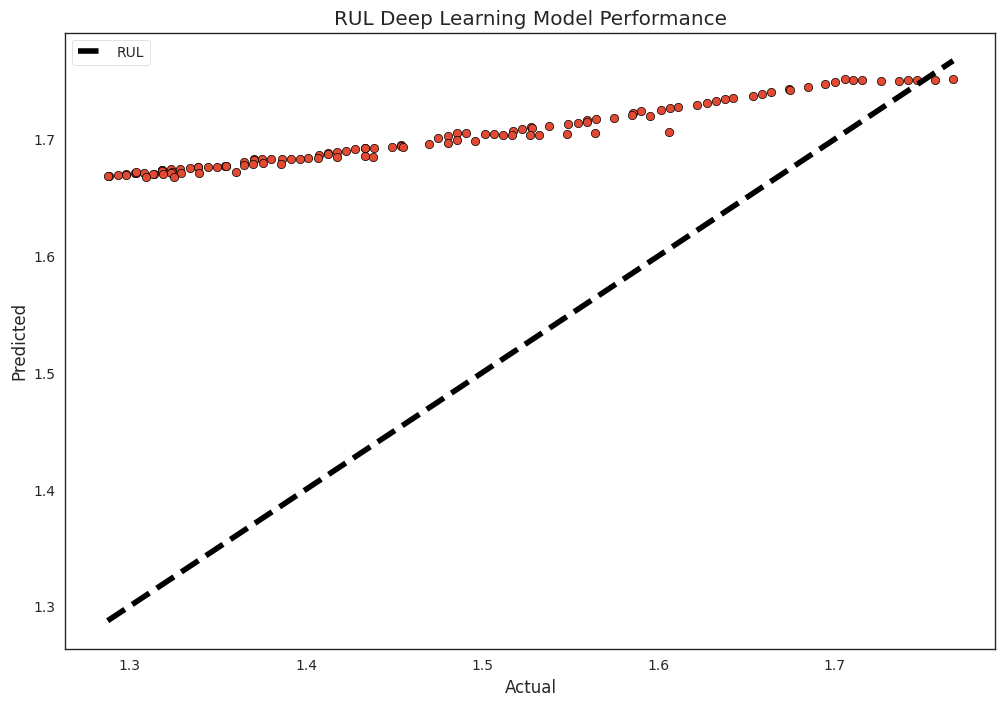

In [ ]:
# plot the predicted values against the actual values
fig, ax = plt.subplots()
ax.scatter(tests, pred, edgecolors=(0, 0, 0))
ax.plot([tests.min(), tests.max()], [tests.min(), tests.max()], 'k--', lw=4, label='RUL')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('RUL Deep Learning Model Performance')
plt.legend()
plt.show()

<ipython-input-60-b2290e67f2dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['pre']=pred


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

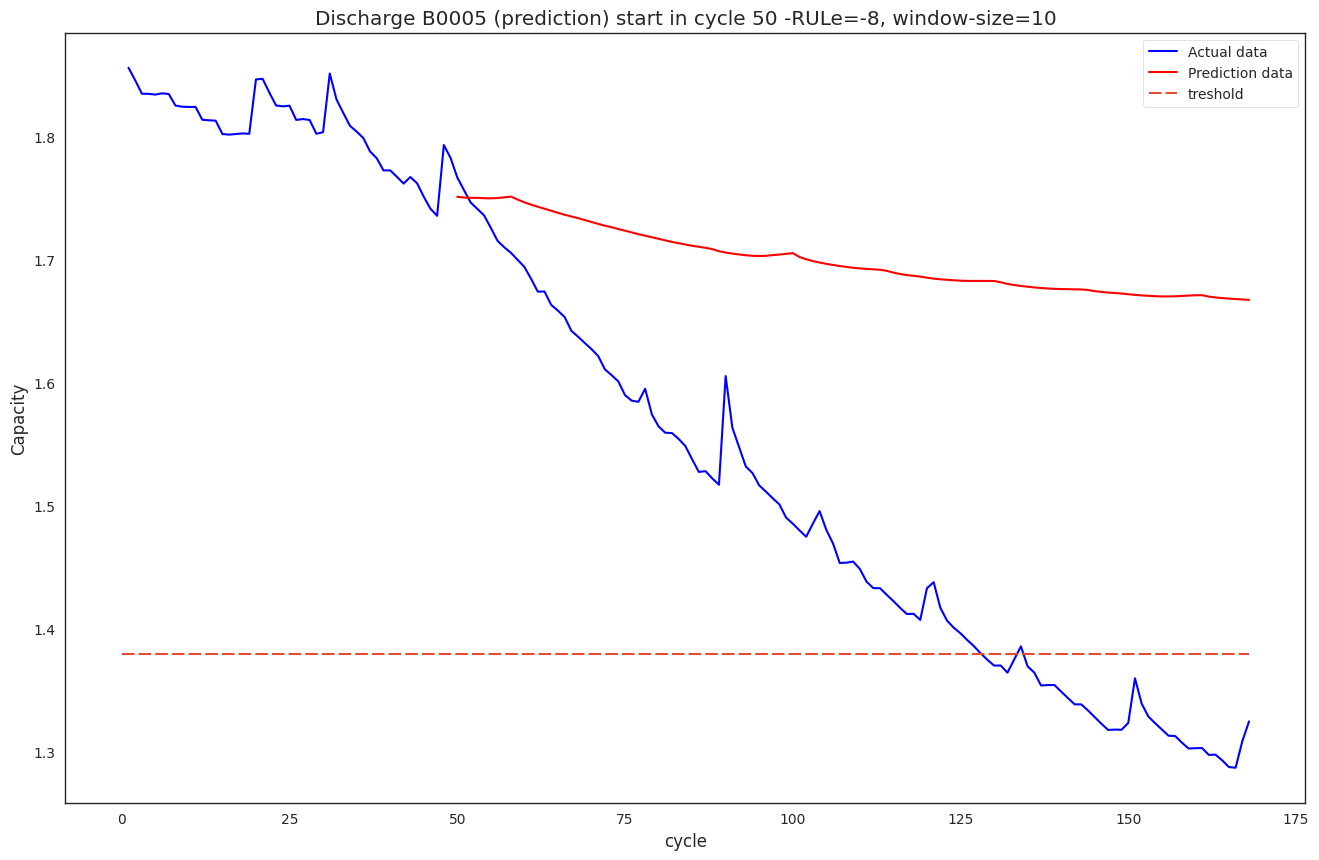

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

In [ ]:
pred=0
Afil=0
Pfil=0
a=data_test['capacity'].values
b=data_test['pre'].values
j=0
k=0
for i in range(len(a)):
    actual=a[i]

    if actual<=1.38:
        j=i
        Afil=j
        break
for i in range(len(a)):
    pred=b[i]
    if pred< 1.38:
        k=i
        Pfil=k
        break
print("The Actual fail at cycle number: "+ str(Afil+ln))
print("The prediction fail at cycle number: "+ str(Pfil+ln))
RULerror=Pfil-Afil
print("The error of RUL= "+ str(RULerror)+ " Cycle(s)")

The Actual fail at cycle number: 128
The prediction fail at cycle number: 49
The error of RUL= -79 Cycle(s)
